<a href="https://colab.research.google.com/github/anthopper/meteorology/blob/main/Meteorology_Explorations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome!
Welcome to the meteorological data, data exploration. You can navigate through the examples using the table of contents to the left. During this self-paced portion, we'll explore an agent based model of climate change, then look into how to make an ISR Graph, an RSR_Map, a NA_RSR_Map, and and ASR_Trend map. This will provide us a begining to use python to explore meteorology data. Then we will continue and explore Air Temperature, the Nino Index, Daily Precipation and RMM1.

# Explore an Agent Based Model of Climate
Here we will explore an agent based model of climate change. to get started, press setup, and then go. What do you notice? Next, Try increasing the light, or the albedo and see how it impacts global temperature.

## Find the model here:
http://www.netlogoweb.org/launch#http://ccl.northwestern.edu/netlogo/models/models/Sample%20Models/Earth%20Science/Climate%20Change.nlogo


# Setup the Programming Environment
Run the block below before anything else. It installs and makes ready the import parts of the python code, such as code to display maps (cartopy) and perform scientific computing tasks with large web-based data (numpy and pandas). 

Each time you re-open this workbook you will need to run the code below, as this environment is temporary, only lasting as long as you have this tab open in your browser.

In [1]:
!pip install cartopy

!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
import pandas as pd
import scipy.io.netcdf as sp

import netCDF4 as nc

import cartopy
import cartopy.crs as ccrs             # for projections
import cartopy.feature as cf           # for features
import cartopy.io.shapereader as shapereader
from cartopy.util import add_cyclic_point
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.feature.nightshade import Nightshade



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.8 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 38.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 31.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 42.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 46 kB 3.5 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516299 sha256=e55740d4027f30f781529ff75365c3b6fd2b0e218fa96b604d33d5c5930a9972
  Stored in directory: /root/.cache/pip/whee

Next we will give Google Collabor permission to access our drive.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ISR Graph
This script creates a scatter plot of the global mean ISR over time.

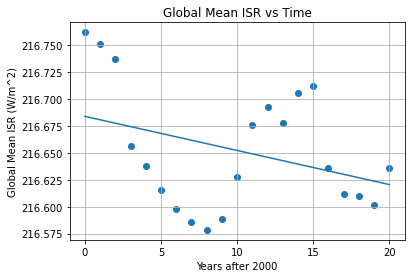

In [9]:
# Open the dataset file
fileObj = sp.NetCDFFile('/content/drive/Shared drives/Research Project Data/CERES_EBAF-TOA_Ed4.1_Subset_200003-202111.nc', 'r')

# Make variables to store all the ISR and latitude values
ISR = fileObj.variables['solar_mon'][:]
lat = fileObj.variables['lat'][:]

# Calculate how many full years of data is in the dataset
numYears = ISR.shape[0] // 12

# Create an array that stores a value for each year after 2000, with the year 2000 at index 0
years = np.arange(numYears)

# Create an array, with 0s as placeholders, that will be used to store the global mean ISR of each year
yearlyGlobalMeanISR = np.zeros(numYears)

# Loop through each year and calculate the global mean ISR during that time
for i in range(numYears):
    # Store 12 months of ISR data
    oneYearISR = ISR[i*12:i*12+12, :, :]
    
    # Average the data at each location across all 12 months
    meanYearISR = oneYearISR.mean(axis=0)
    
    # Average the data all longitude coordinates
    meanYearLonISR = meanYearISR.mean(axis=1)
    
    # Weight the data depending on its latitude coordinates, with data from locations farther from the equator given less weight since it represents a smaller area
    for j in range(lat.shape[0]):
        meanYearLonISR[j] *= np.cos(lat[j] * np.pi/180)
    
    # Average the data across all latitude coordinates
    yearlyGlobalMeanISR[i] = meanYearLonISR.mean(axis=0)

# Calculate the slope, y-intercept, and correlation coefficient of the best-fit line through the ISR-vs-time points
m, b = np.polyfit(years, yearlyGlobalMeanISR, 1)
r = np.corrcoef(years, yearlyGlobalMeanISR)[0,1]

# Create a scatter plot of the global mean ISR values over time, and then plot the best-fit line through the points
plt.scatter(years, yearlyGlobalMeanISR)
plt.plot(years, m * years + b)

# Adjust the viewing window of the graph, and place a text box containing the equation of the best-fit line and value of the correlation coefficient. Un-comment the next two lines by deleting the '#'s for this to take effect.
#plt.axis([0, 20, 0, 400])
#plt.text(10, 50, 'ISR = ' + f'{m:.4g}' + '*t + ' + f'{b:.4g}' + '\nr = ' + f'{r:.4g}')

# Add a title and labels to the horizontal and vertical axes. Then adjust how many ticks are on the horizontal axis and add gridlines.
plt.title('Global Mean ISR vs Time')
plt.xlabel('Years after 2000')
plt.ylabel('Global Mean ISR (W/m^2)')
plt.locator_params(axis='x', nbins=5)
plt.grid()

# Save a PNG image of the graph

plt.savefig('ISR_Graph', bbox_inches='tight', dpi=200)

# RSR_Map
This script creates a global contour map of the mean RSR values at each location

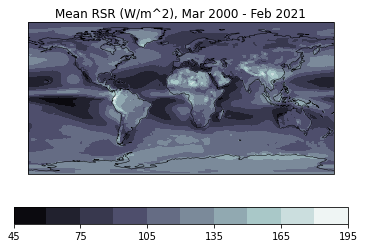

In [5]:
# Open the dataset file
fileObj = sp.NetCDFFile('/content/drive/Shared drives/Research Project Data/CERES_EBAF-TOA_Ed4.1_Subset_200003-202111.nc', 'r')

# Make variables to store all the RSR, latitude, and longitude values
RSR = fileObj.variables['toa_sw_all_mon'][:]
lat = fileObj.variables['lat'][:]
lon = fileObj.variables['lon'][:]

# Calculate how many full years of data is in the dataset
numYears = RSR.shape[0] // 12

# Take a subset of the data in which the extra months at the end that are not part of a full year are excluded
fullYearRSR = RSR[0:numYears * 12, :, :]

# Average the data at each location across all months
means = fullYearRSR.mean(axis=0)

# Fix problem with 0 longitude missing data
means, lon = add_cyclic_point(means, coord=lon)

# Set up a global map using the Plate Carree projection and add coastlines
axes = plt.axes(projection=ccrs.PlateCarree())
axes.add_feature(cf.COASTLINE, linewidth=0.5)

# Overlay the contours onto the map based on the mean RSR values at each location. Include a color bar and add a title
plt.contourf(lon[:], lat[:], means[:,:], levels=12, cmap='bone')
plt.colorbar(orientation='horizontal')
plt.title('Mean RSR (W/m^2), Mar 2000 - Feb 2021')

# Save a PNG image of the map
plt.savefig('RSR_Map.png', bbox_inches='tight', dpi=200)

# projection options: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html
# cmap options: https://matplotlib.org/stable/tutorials/colors/colormaps.html

# NA_RSR_Map
This script creates a global contour map of the mean RSR values at each location.

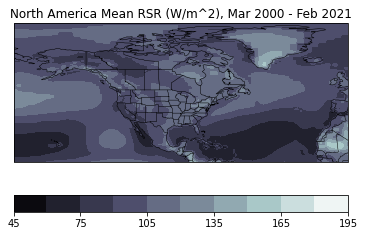

In [10]:
# Open the dataset file
fileObj = sp.NetCDFFile('/content/drive/Shared drives/Research Project Data/CERES_EBAF-TOA_Ed4.1_Subset_200003-202111.nc', 'r')

# 1 - Make variables to store all the RSR, latitude, and longitude values
RSR = fileObj.variables['toa_sw_all_mon'][:]
lat = fileObj.variables['lat'][:]
lon = fileObj.variables['lon'][:]


# 2 - Calculate how many full years of data is in the dataset
numYears = RSR.shape[0] // 12


# 3 - Take a subset of the data in which the extra months at the end that are not part of a full year are excluded
fullYearRSR = RSR[0:numYears * 12, :, :]


# 4 - Average the data at each location across all months
means = fullYearRSR.mean(axis=0)


# 5 - Fix problem with 0 longitude missing data
means, lon = add_cyclic_point(means, coord=lon)


# 6 - Set up a global map using the Plate Carree projection and add coastlines
axes = plt.axes(projection=ccrs.PlateCarree())
axes.add_feature(cf.COASTLINE, linewidth=0.5)


axes.set_extent([-180, 0, 10, 85], crs=ccrs.PlateCarree())
axes.add_feature(cf.BORDERS, linewidth=0.5)
axes.add_feature(cf.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='50m', facecolor='none', linewidth=0.5), edgecolor='black')


# 7 - Overlay the contours onto the map based on the mean RSR values at each location. Include a color bar and add a title
plt.contourf(lon[:], lat[:], means[:,:], levels=12, cmap='bone')
plt.colorbar(orientation='horizontal')
plt.title('North America Mean RSR (W/m^2), Mar 2000 - Feb 2021')


# 8 - Save a PNG image of the map
plt.savefig('NA_RSR_Map.png', bbox_inches='tight', dpi=200)

# ASR_Trend_Map
This script creates a global contour map of the trend in ASR values at each location.

-1.6216274905514405
0.9051083255123793


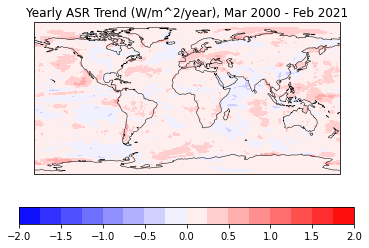

In [7]:
# Open the dataset file
fileObj = sp.NetCDFFile('/content/drive/Shared drives/Research Project Data/CERES_EBAF-TOA_Ed4.1_Subset_200003-202111.nc', 'r')

# Make variables to store all the ISR, RSR, latitude, and longitude values
ISR = fileObj.variables['solar_mon'][:]
RSR = fileObj.variables['toa_sw_all_mon'][:]
lat = fileObj.variables['lat'][:]
lon = fileObj.variables['lon'][:]

# Calculate how many full years of data is in the dataset
numYears = ISR.shape[0] // 12

# Create an array that stores a value for each year after 2000, with the year 2000 at index 0
years = np.arange(numYears)

# Calculate the ASR values based on the ISR and RSR
ASR = ISR[:,:,:] - RSR[:,:,:]

# Take a subset of the data in which the extra months at the end that are not part of a full year are excluded
fullYearASR = ASR[0:numYears * 12, :, :]

# Create an array, with 0s as placeholders, that will be used to store the mean ASR of each year at each location
annualASR = np.zeros((numYears, fullYearASR.shape[1], fullYearASR.shape[2]))

# Loop through each year and calculate the global mean ASR during that time at each loaction
for i in range(numYears):
    oneYearASR = ASR[i*12:i*12+12, :, :]
    annualASR[i,:,:] = oneYearASR.mean(axis=0)

# Create an array, with 0s as placeholders, that will be used to store the slopes of the trendlines through ASR-vs-time points at each location
slopes = np.zeros((annualASR.shape[1], annualASR.shape[2]))

# Loop through each latitude and longitude location and calculate the slopes of the trendlines through ASR-vs-time points at each location
for i in range(slopes.shape[0]):
    for j in range(slopes.shape[1]):
        m, b = np.polyfit(years, annualASR[:,i,j], 1)
        slopes[i,j] = m

# Fix problem with 0 longitude missing data
slopes, lon = add_cyclic_point(slopes, coord=lon)

# Print to the console the miniumum and maximum slope values
print(slopes.min())
print(slopes.max())

# Set up a global map using the Plate Carree projection and add coastlines
axes = plt.axes(projection=ccrs.PlateCarree())
axes.add_feature(cf.COASTLINE, linewidth=0.5)

# Overlay the contours onto the map based on the slopes of the trendlines at each location. Include a color bar and add a title
plt.contourf(lon[:], lat[:], slopes[:,:], levels=np.arange(-2, 2.25, 0.25), cmap='bwr')
plt.colorbar(orientation='horizontal')
plt.title('Yearly ASR Trend (W/m^2/year), Mar 2000 - Feb 2021')

# Save a PNG image of the map
plt.savefig('ASR_Trend_Map.png', bbox_inches='tight', dpi=200)

# projection options: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html
# cmap options: https://matplotlib.org/stable/tutorials/colors/colormaps.html

# Air Temperature Map
This script creates a global contour map of the mean air temperature values at each location.

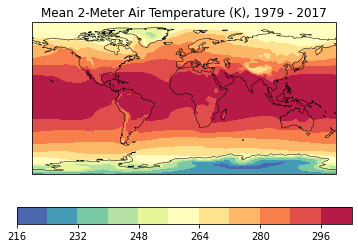

In [ ]:
# Open the dataset file
f = nc.Dataset('/content/drive/Shared drives/Research Project Data/CSATS/t2m.daily_mean.1979-2017.nc', 'r')

# Make variables to store all the temperature, latitude, and longitude values
temp = f.variables['t2m'][:]
lat = f.variables['latitude'][:]
lon = f.variables['longitude'][:]

# Average the data at each location across all months. Fix problem with 0 longitude missing data
means = temp.mean(axis=0)
means, lon = add_cyclic_point(means, coord=lon)

# Set up a global map using the Plate Carree projection and add coastlines
axes = plt.axes(projection=ccrs.PlateCarree())
axes.add_feature(cf.COASTLINE, linewidth=0.5)

# Overlay the contours onto the map based on the mean temperature values at each location. Include a color bar and add a title
plt.contourf(lon[:], lat[:], means[:,:], levels=12, cmap='Spectral_r')
plt.colorbar(orientation='horizontal')
plt.title('Mean 2-Meter Air Temperature (K), 1979 - 2017')

# Save a PNG image of the map. Click the "folder" icon the left to view your saved images.
plt.savefig('AirTemp_Map.png', bbox_inches='tight', dpi=200)

## Air Temperature Graph
Next, we'll create a script for a scatter plot of the global mean air temperature by year. 

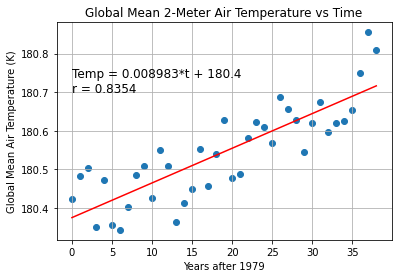

In [ ]:
# Open the dataset file
f = nc.Dataset('/content/drive/Shared drives/Research Project Data/CSATS/t2m.daily_mean.1979-2017.nc', 'r')

# Make variables to store all the temperature and latitude values
temp = f.variables['t2m'][:]
lat = f.variables['latitude'][:]

# Calculate how many full years of data are in the dataset
numYears = temp.shape[0] // 365

# Create an array that stores a value for each year after 1979, with the year 1979 at index 0
years = np.arange(numYears)

# Create an array, with 0s as placeholders, that will be used to store the global mean air temperature of each year
yearlyGlobalMeanTemp = np.zeros(numYears)

# Loop through each year and calculate the global mean air temperature during that time
for i in range(numYears):
    # Decide how many days were in the current year (first year: 1979)
    numDaysInYear = 365
    if ((i - 1) % 4 == 0):
        numDaysInYear = 366
    
    # Store one year of temperature data
    oneYearTemp = temp[(i * numDaysInYear):(i * numDaysInYear + numDaysInYear), :, :]
    
    # Average the data at each location across all 12 months
    meanYearTemp = oneYearTemp.mean(axis=0)
    
    # Average the data all longitude coordinates
    meanYearLonTemp = meanYearTemp.mean(axis=1)
    
    # Weight the data depending on its latitude coordinates, with data from locations farther from the equator given less weight since it represents a smaller area
    for j in range(lat.shape[0]):
        meanYearLonTemp[j] *= np.cos(lat[j] * np.pi/180)
    
    # Average the data across all latitude coordinates
    yearlyGlobalMeanTemp[i] = meanYearLonTemp.mean(axis=0)

# Calculate the slope, y-intercept, and correlation coefficient of the best-fit line through the temperature-vs-time points
m, b = np.polyfit(years, yearlyGlobalMeanTemp, 1)
r = np.corrcoef(years, yearlyGlobalMeanTemp)[0,1]

# Create a scatter plot of the global mean ISR values over time, and then plot the best-fit line through the points
plt.scatter(years, yearlyGlobalMeanTemp)
plt.plot(years, m * years + b, color='red')

# Adjust the viewing window of the graph, and place a text box containing the equation of the best-fit line and value of the correlation coefficient.
#plt.axis([0, 20, 0, 400])
plt.text(0, 180.7, 'Temp = ' + f'{m:.4g}' + '*t + ' + f'{b:.4g}' + '\nr = ' + f'{r:.4g}', fontsize=12)

# Add a title and labels to the horizontal and vertical axes. Then adjust how many ticks are on the horizontal axis and add gridlines.
plt.title('Global Mean 2-Meter Air Temperature vs Time')
plt.xlabel('Years after 1979')
plt.ylabel('Global Mean Air Temperature (K)')
plt.grid()

plt.savefig('Air Temperture Graph', bbox_inches='tight', dpi=200)

# Graph of Nino 3.4 index data
This is an example  of using data from a web wharehouse, insteasd of our own Google drive. Here we'll import the data directly from web sources. This is a useful featute of the pandas package (written as pd below).

This script creates a graph of Nino 3.4 index data.

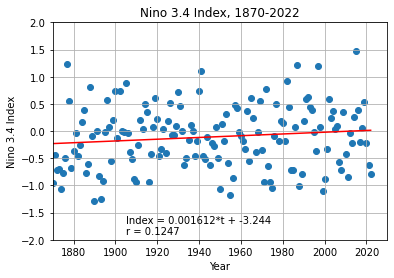

In [ ]:
# Open the dataset file, separating by whitespaces. Skip first row, which does not have data.
# Set column 0 (which stores years) as the index column.

f = pd.read_csv('https://psl.noaa.gov/gcos_wgsp/Timeseries/Data/nino34.long.anom.data',
                sep='\s+', skiprows=1, index_col=0, header=None)

# Get a subset of the dataset that ignores the last 7 rows that have non-data information.
# Then convert the data to numbers and mark missing entries.
data = f.iloc[0:-7]
data = data.apply(pd.to_numeric)
data.index = pd.to_numeric(data.index)
data = data.replace(-99.99, np.NaN)

# Create a column that stores the mean value for each year.
data['mean'] = data.mean(axis=1)

# Get the slope, y-intercept, and correlation coefficient for the best-fit line through the means each year.
m, b = np.polyfit(data.index, data['mean'], 1)
r = np.corrcoef(data.index, data['mean'])[0,1]

# Create a scatter plot of the means each year and overlay the best-fit line.
plt.scatter(data.index, data['mean'])
plt.plot(data.index, m * data.index + b, color='red')

# Adjust the scales of the axes and add text for linear regression
plt.axis([1870, 2030, -2, 2])
plt.text(1905, -1.9, 'Index = ' + f'{m:.4g}' + '*t + ' + f'{b:.4g}' + '\nr = ' + f'{r:.4g}')

# Add a graph title, axis labels, and a grid to the graph.
plt.title('Nino 3.4 Index, 1870-2022')
plt.xlabel('Year')
plt.ylabel('Nino 3.4 Index')
plt.grid()

# Save a PNG image of the graph
plt.savefig('Nino-Year_Graph.png', bbox_inches='tight', dpi=200)

# Global Daily Precipitation
This script creates a scatter plot of the global mean daily precipitation by year.

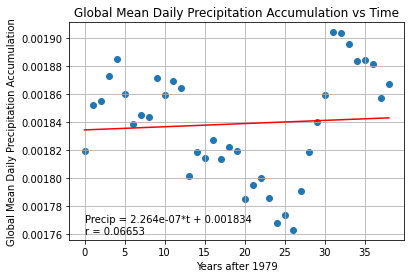

In [ ]:
# Open the dataset file
f = nc.Dataset('/content/drive/Shared drives/Research Project Data/CSATS/tp.daily_accumulation.1979-2017.nc', 'r')

# Make variables to store all the precipitation and latitude values
precip = f.variables['tp'][:]
lat = f.variables['latitude'][:]

# Calculate how many full years of data are in the dataset
numYears = precip.shape[0] // 365

# Create an array that stores a value for each year after 1979, with the year 1979 at index 0
years = np.arange(numYears)

# Create an array, with 0s as placeholders, that will be used to store the global mean daily precipitation of each year
yearlyGlobalMeanPrecip = np.zeros(numYears)

# Loop through each year and calculate the global mean precipitation during that time
for i in range(numYears):
    # Decide how many days were in the current year (first year: 1979)
    numDaysInYear = 365
    if ((i - 1) % 4 == 0):
        numDaysInYear = 366
    
    # Store one year of precipitation data
    oneYearPrecip = precip[(i * numDaysInYear):(i * numDaysInYear + numDaysInYear), :, :]
    
    # Average the data at each location across all 12 months
    meanYearPrecip = oneYearPrecip.mean(axis=0)
    
    # Average the data all longitude coordinates
    meanYearLonPrecip = meanYearPrecip.mean(axis=1)
    
    # Weight the data depending on its latitude coordinates, with data from locations farther from the equator given less weight since it represents a smaller area
    for j in range(lat.shape[0]):
        meanYearLonPrecip[j] *= np.cos(lat[j] * np.pi/180)
    
    # Average the data across all latitude coordinates
    yearlyGlobalMeanPrecip[i] = meanYearLonPrecip.mean(axis=0)

# Calculate the slope, y-intercept, and correlation coefficient of the best-fit line through the temperature-vs-time points
m, b = np.polyfit(years, yearlyGlobalMeanPrecip, 1)
r = np.corrcoef(years, yearlyGlobalMeanPrecip)[0,1]

# Create a scatter plot of the global mean ISR values over time, and then plot the best-fit line through the points
plt.scatter(years, yearlyGlobalMeanPrecip)
plt.plot(years, m * years + b, color='red')

# Adjust the viewing window of the graph, and place a text box containing the equation of the best-fit line and value of the correlation coefficient.
#plt.axis([0, 20, 0, 400])
plt.text(0, 0.00176, 'Precip = ' + f'{m:.4g}' + '*t + ' + f'{b:.4g}' + '\nr = ' + f'{r:.4g}')

# Add a title and labels to the horizontal and vertical axes. Then adjust how many ticks are on the horizontal axis and add gridlines.
plt.title('Global Mean Daily Precipitation Accumulation vs Time')
plt.xlabel('Years after 1979')
plt.ylabel('Global Mean Daily Precipitation Accumulation')
plt.grid()

# Save a PNG image of the graph
plt.savefig('Precip-Year_Graph.png', bbox_inches='tight', dpi=200)

## Map
This script creates a global contour map of the mean precipitation accumulation values at each location.

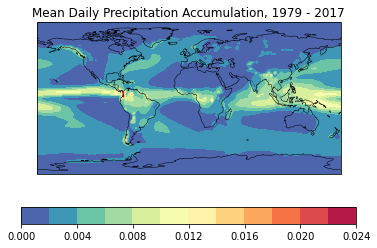

In [ ]:
# Open the dataset file
f = nc.Dataset('/content/drive/Shared drives/Research Project Data/CSATS/tp.daily_accumulation.1979-2017.nc', 'r')

# Make variables to store all the precipitation, latitude, and longitude values
precip = f.variables['tp'][:]
lat = f.variables['latitude'][:]
lon = f.variables['longitude'][:]

# Average the data at each location across all months. Fix problem with 0 longitude missing data
means = precip.mean(axis=0)
means, lon = add_cyclic_point(means, coord=lon)

# Set up a global map using the Plate Carree projection and add coastlines
axes = plt.axes(projection=ccrs.PlateCarree())
axes.add_feature(cf.COASTLINE, linewidth=0.5)

# Overlay the contours onto the map based on the mean precipitation values at each location. Include a color bar and add a title
plt.contourf(lon[:], lat[:], means[:,:], levels=12, cmap='Spectral_r')
plt.colorbar(orientation='horizontal')
plt.title('Mean Daily Precipitation Accumulation, 1979 - 2017')

# Save a PNG image of the map
plt.savefig('Precip_Map.png', bbox_inches='tight', dpi=200)

# RMM1 data each day
This script creates a graph of RMM1 data each day.

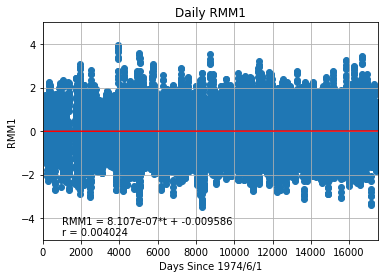

In [ ]:
# Open the dataset file, separating by whitespaces. Skip first two rows, which do not have data.
f = pd.read_csv('/content/drive/Shared drives/Research Project Data/CSATS/rmm.74toRealtime.txt',
                sep='\s+', skiprows=2, header=None)

# Get a subset of the dataset that ignores the last 2 columns that have unimportant information.
# Then convert the data to numbers and mark missing entries. Finally, name the columns.
data = f.iloc[:, :6]
data = data.apply(pd.to_numeric)
data[data > 900] = np.NaN
data.rename(columns={0:'year', 1:'month', 2:'day', 3:'RMM1', 4:'RMM2', 5:'phase'}, inplace=True)

# Identify missing entries. Get the slope, y-intercept, and correlation coefficient for the best-fit line through the non-missing RMM1 each day.
idx = np.isfinite(data['RMM1'])
m, b = np.polyfit(data.index[idx], data['RMM1'][idx], 1)
r = np.corrcoef(data.index[idx], data['RMM1'][idx])[0,1]

# Create a scatter plot of the RMM1 each day and overlay the best-fit line.
plt.scatter(data.index, data['RMM1'])
plt.plot(data.index, m * data.index + b, color='red')

# Adjust the scales of the axes and add text for linear regression
plt.axis([0, 17500, -5, 5])
plt.text(1000, -4.8, 'RMM1 = ' + f'{m:.4g}' + '*t + ' + f'{b:.4g}' + '\nr = ' + f'{r:.4g}')

# Add a graph title, axis labels, and a grid to the graph.
plt.title('Daily RMM1')
plt.xlabel('Days Since 1974/6/1')
plt.ylabel('RMM1')
plt.grid()

# Save a PNG image of the graph
plt.savefig('RMM1-Daily_Graph.png', bbox_inches='tight', dpi=1000)

Thank you for exploring this data with us!